# Prototype: beta

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `10.000`|
| *Adversarial Attack* | `CW` |
| *Explanations* | `SHAP` |


---

In [28]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [29]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 5000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=42)
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Splitting labels and features ---
--- Encoding labels as binary one

## Split Data

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)


## Create IDS

In [31]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# build ids with complete dataset
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

Epoch 1/20


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8632 - loss: 0.4780 - val_accuracy: 0.9781 - val_loss: 0.0630
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9790 - loss: 0.0617 - val_accuracy: 0.9837 - val_loss: 0.0415
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9815 - loss: 0.0457 - val_accuracy: 0.9850 - val_loss: 0.0343
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9826 - loss: 0.0391 - val_accuracy: 0.9850 - val_loss: 0.0300
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9842 - loss: 0.0348 - val_accuracy: 0.9856 - val_loss: 0.0272
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9850 - loss: 0.0317 - val_accuracy: 0.9856 - val_loss: 0.0259
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9875 - loss: 0.0294 - val_accuracy: 0.9856 - val_loss: 0.0244
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0274 - val_accuracy: 0.9869 - 

2025-04-07 15:14:25.537001: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


## Generate Attacks

In [32]:
import functions.attack_generator as ag
import importlib
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# create smaller dataset
X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

import numpy as np
target_label = np.zeros_like(y_train)
target_label[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN
# print(target_label[:3])

import multiprocessing
num_cores = multiprocessing.cpu_count()

X_adv = ag.generate_cw_attacks_parallel(art_model, X_train, target_label=target_label, num_cores=num_cores)
# print(X_adv_fgsm.iloc[:, :3].head(2))

y_pred_adv = ag.evaluate_art_model(art_model, X_adv, y_train)
print(y_pred_adv.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)
Running attack using 24 CPU cores...

Process 124912 is generating adversarial examples for batch of size 333 
Process 124914 is generating adversarial examples for batch of size 333 
Process 124913 is generating adversarial examples for batch of size 333 

Process 124915 is generating adversarial examples for batch of size 333 

Process 124917 is generating adversarial examples for batch of size 333 
Process 124916 is generating adversarial examples for batch of size 333 
Process 124918 is generating adversarial examples for batch of size 333 
Process 124919 is generating adversarial examples for batch of size 333 



Process 124920 is generating adversarial examples for batch of size 333 



Process 124922 is generating adversarial examples for batch of size 333 
Process 124921 is generating adversarial examples for batch of size 333 
Process 124923 is generating adversarial examples for batch of size 333 

Process 124924 is generating advers

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/333 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/341 [00:00<?, ?it/s]

Accuracy: 98.76%
              precision    recall  f1-score   support

      ATTACK     0.9765    0.9992    0.9877      3988
      BENIGN     0.9992    0.9761    0.9875      4012

    accuracy                         0.9876      8000
   macro avg     0.9879    0.9877    0.9876      8000
weighted avg     0.9879    0.9876    0.9876      8000

Confusion Matrix: Positive == BENIGN
TN: 3985, FP: 3, FN: 96, TP: 3916
(8000, 2)


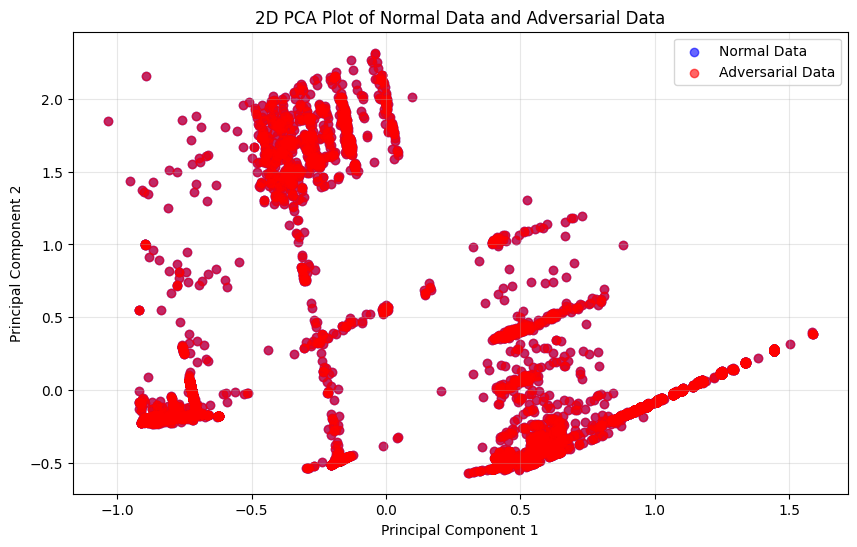

In [33]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train, 'Normal Data', X_adv, 'Adversarial Data')

## Explainer

In [34]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values_df = exp.generate_shap_values(explainer, X_train)
print(shap_values_df.shape)

shap_values_adv_df = exp.generate_shap_values(explainer, X_adv)
print(shap_values_adv_df.shape)

PermutationExplainer explainer: 8001it [04:07, 31.09it/s]                          


(8000, 70)


PermutationExplainer explainer: 8001it [04:11, 30.57it/s]                          


(8000, 70)


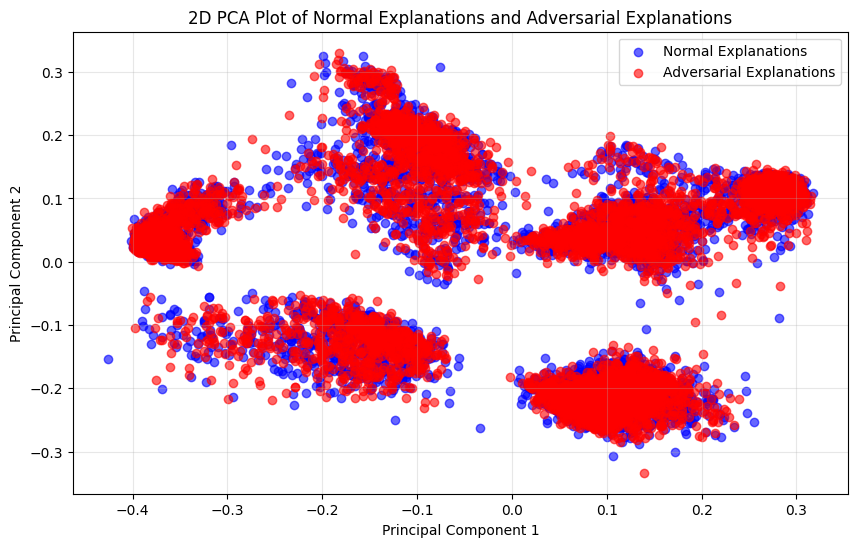

In [35]:
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

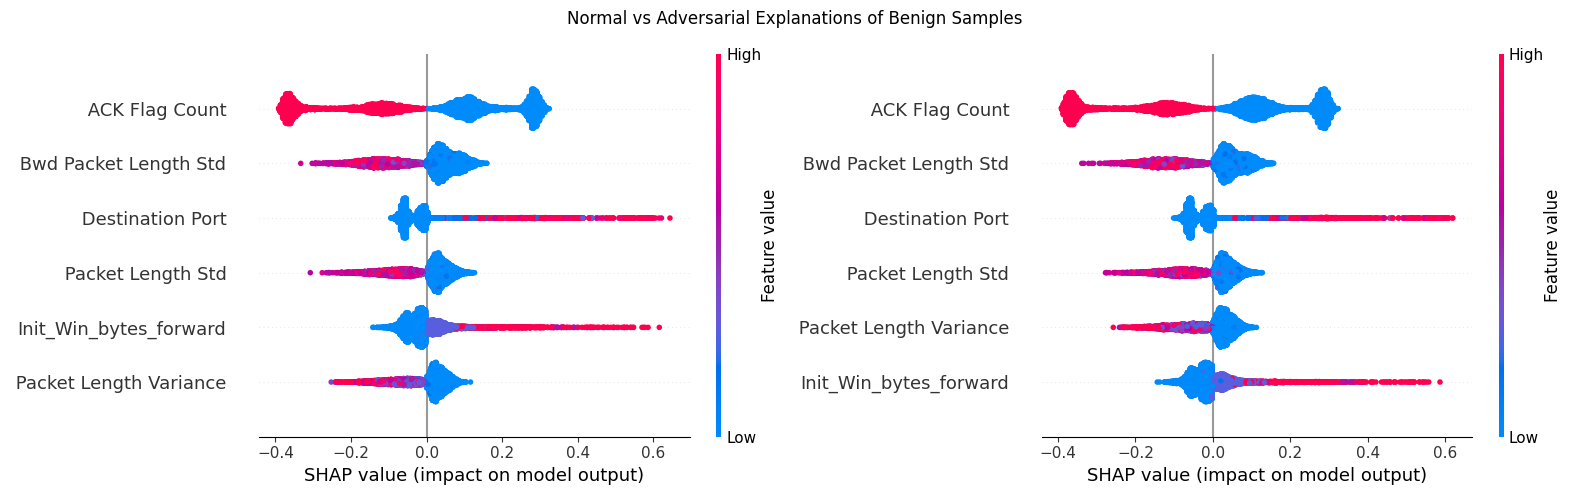

In [36]:
exp.plot_shap_summary_comparison(shap_values_df.values, X_train, shap_values_adv_df.values, X_adv, 6, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [37]:
import functions.detector as det
import importlib
importlib.reload(det)

# create dataframe
class_samples = {
    'BENIGN': shap_values_df,
    'ADVERSARIAL': shap_values_adv_df,
}
X, y = det.build_detector_dataset(class_samples)
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

Generated dataset: X shape (16000, 70), y shape (16000, 2)
(16000, 70) (16000, 2)
(14400, 70) (1600, 70) (14400, 2) (1600, 2)
Epoch 1/20


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5045 - loss: 0.6933 - val_accuracy: 0.4951 - val_loss: 0.6935
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5101 - loss: 0.6931 - val_accuracy: 0.4955 - val_loss: 0.6935
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5013 - loss: 0.6933 - val_accuracy: 0.4878 - val_loss: 0.6934
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.4927 - loss: 0.6933 - val_accuracy: 0.4812 - val_loss: 0.6934
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4899 - val_loss: 0.6935
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.5057 - loss: 0.6931 - val_accuracy: 0.4892 - val_loss: 0.6934
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4958 - val_loss: 0.6935
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy:

### Comparator - Normal Detector: Based on Raw Data

In [38]:
class_samples = {
    'BENIGN': X_train,
    'ADVERSARIAL': X_adv,
}
X, y = det.build_detector_dataset(class_samples)
print(X.shape, y.shape)

X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

Generated dataset: X shape (16000, 70), y shape (16000, 2)
(16000, 70) (16000, 2)
(14400, 70) (1600, 70) (14400, 2) (1600, 2)
Epoch 1/20


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5019 - loss: 0.6950 - val_accuracy: 0.4920 - val_loss: 0.6935
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.5037 - loss: 0.6933 - val_accuracy: 0.4931 - val_loss: 0.6934
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.4908 - loss: 0.6935 - val_accuracy: 0.4955 - val_loss: 0.6933
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.4857 - loss: 0.6937 - val_accuracy: 0.4927 - val_loss: 0.6932
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.5009 - loss: 0.6933 - val_accuracy: 0.4948 - val_loss: 0.6932
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.4948 - val_loss: 0.6933
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.4981 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.5062 - loss: 0.6932 - val_accuracy:

---
## Test Process

In [39]:
print(X_test.shape)

(2000, 70)


### Generate Attacks

In [40]:
X_test_adv = ag.generate_fgsm_attacks(art_model, X_test)

Adversarial FGSM examples generated. Shape: (2000, 70)


### Generate Explanations

In [41]:
X_test_adv_shap_values_df = exp.generate_shap_values(explainer, X_test_adv)
X_test_shap_values_df = exp.generate_shap_values(explainer, X_test)

PermutationExplainer explainer: 2001it [00:57, 28.79it/s]                          
PermutationExplainer explainer: 2001it [01:04, 26.19it/s]                          


### Generate Datasets

In [42]:
class_samples = {
    'BENIGN': X_test_shap_values_df,
    'ADVERSARIAL': X_test_adv_shap_values_df,
}
X, y = det.build_detector_dataset(class_samples)

Generated dataset: X shape (4000, 70), y shape (4000, 2)


### Preprocess Data

In [43]:
# print(np.max(X))
# print(np.min(X))
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

### Shuffle Data & Predict

In [44]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

y_pred = detector.predict(X)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


### Evaluate

In [45]:
det.evaluate_model(y_pred, y)

Global Accuracy: 50.00%
              precision    recall  f1-score   support

 ADVERSARIAL     0.5000    1.0000    0.6667      2000
      BENIGN     0.0000    0.0000    0.0000      2000

    accuracy                         0.5000      4000
   macro avg     0.2500    0.5000    0.3333      4000
weighted avg     0.2500    0.5000    0.3333      4000

True Negative Rate: 100.00%
False Positive Rate: 0.00%
True Positive Rate: 0.00%
False Negative Rate: 100.00%


---
## Additional Evaluation - New Samples

In [46]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

X_eval, y_eval, _ = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=500, random_sample_state=17)
print(y_eval.value_counts())

-- Preprocessing data --
--- Splitting labels and features ---


--- Encoding labels as binary one-hot values ---
--- Sampling balanced data ---
Sample to shape: (1000, 70)
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      500
True    False     500
Name: count, dtype: int64


In [47]:
X_adv_fgsm_eval = ag.generate_fgsm_attacks(art_model, X_eval)
print(X_adv_fgsm_eval.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm_eval, y_eval)

Adversarial FGSM examples generated. Shape: (1000, 70)
        Destination Port  Flow Duration  Total Fwd Packets
330666          0.101221       0.149907                0.0
449157          0.101221       0.200072                0.0
Accuracy: 14.70%
              precision    recall  f1-score   support

      ATTACK     0.0000    0.0000    0.0000       500
      BENIGN     0.2272    0.2940    0.2563       500

    accuracy                         0.1470      1000
   macro avg     0.1136    0.1470    0.1282      1000
weighted avg     0.1136    0.1470    0.1282      1000

Confusion Matrix: Positive == BENIGN
TN: 0, FP: 500, FN: 353, TP: 147


,BENIGN,ATTACK
330666,True,False
449157,True,False
394344,True,False
445488,True,False
483638,True,False
...,...,...
2485393,False,True
2370735,False,True
1575488,False,True
947471,False,True


In [48]:
X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_fgsm_eval)
X_eval_shap_values_df = exp.generate_shap_values(explainer, X_eval)

PermutationExplainer explainer: 1001it [00:28, 23.52it/s]                         
PermutationExplainer explainer: 1001it [00:31, 21.51it/s]                          


In [49]:
class_samples = {
    'BENIGN': X_eval_shap_values_df,
    'ADVERSARIAL': X_eval_adv_shap_values_df,
}
X_eval_detector, y_eval_detector = det.build_detector_dataset(class_samples)
print(X_eval_detector.shape, y_eval_detector.shape)

Generated dataset: X shape (2000, 70), y shape (2000, 2)
(2000, 70) (2000, 2)


In [50]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

 1/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


2025-04-07 15:46:53.603081: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [51]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 49.95%
              precision    recall  f1-score   support

 ADVERSARIAL     0.4997    0.9990    0.6662      1000
      BENIGN     0.0000    0.0000    0.0000      1000

    accuracy                         0.4995      2000
   macro avg     0.2499    0.4995    0.3331      2000
weighted avg     0.2499    0.4995    0.3331      2000

True Negative Rate: 99.90%
False Positive Rate: 0.10%
True Positive Rate: 0.00%
False Negative Rate: 100.00%
